In [ ]:
# default_exp DSsplitter

# DSsplitter

> Functions for `Random Split` and `Scaffold Split`

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
# export

from rdkit import Chem
from rdkit.Chem.Scaffolds import MurckoScaffold
from collections import defaultdict
from typing import Dict, List, Set, Tuple, Union
import random

def generate_scaffold(smi: str, include_chirality: bool = False):
    """
    Compute the Bemis-Murcko scaffold for a SMILES string.
    - parameters:
        - mol: A SMILES string.
        - include_chirality: Whether to include chirality.
    - return: the SMILES of the scaffold
    """
    mol = Chem.MolFromSmiles(smi)
    scaffold = MurckoScaffold.MurckoScaffoldSmiles(mol=mol, includeChirality=include_chirality)

    return scaffold

def scaffold_to_smiles(data,
                       use_indices: bool = False):
    """
    Computes scaffold for each smiles string and returns a mapping from scaffolds to sets of smiles.
    - parameters:
        - mols: A list of SMILES strings.
        - use_indices: Whether to map to the smiles' index in all_smiles rather than mapping
    to the smiles string itself. This is necessary if there are duplicate smiles.
    - return: A dictionary mapping each unique scaffold to all smiles (or smiles indices) which have that scaffold.
    """
    scaffolds = defaultdict(set)
    for i, smi in enumerate(data):
        scaffold = generate_scaffold(smi)
        if use_indices:
            scaffolds[scaffold].add(i)
        else:
            scaffolds[scaffold].add(smi)

    return scaffolds

def scaffold_split(data,
                   sizes: Tuple[float, float, float] = (0.8, 0.1, 0.1),
                   balanced: bool = True,
                   seed: int = 0):
    """
    Split a dataset by scaffold so that no molecules sharing a scaffold are in the same split.
    - parameters: 
        - data: A list of smiles.
        - sizes: A length-3 tuple with the proportions of data in the train, validation, and test sets.
        - balanced: Try to balance sizes of scaffolds in each set, rather than just putting smallest in test set.
        - seed: Seed for reproducitility.
    - return: two tuples 
        - (1) containing the train, validation, and test splits of the data (SMILES)
        - (2) containing the train, validation, and test splits of the index.
    """
    assert sum(sizes) == 1

    # Split
    train_size, val_size, test_size = sizes[0] * len(data), sizes[1] * len(data), sizes[2] * len(data)
    train_index, val_index, test_index = [], [], []
    train_scaffold_count, val_scaffold_count, test_scaffold_count = 0, 0, 0

    # Map from scaffold to index in the data
    scaffold_to_indices = scaffold_to_smiles(data, use_indices=True)
    
    if balanced:  # Put stuff that's bigger than half the val/test size into train, rest just order randomly
        index_sets = list(scaffold_to_indices.values())
        big_index_sets = []
        small_index_sets = []
        for index_set in index_sets:
            if len(index_set) > val_size / 2 or len(index_set) > test_size / 2:
                big_index_sets.append(index_set)
            else:
                small_index_sets.append(index_set)
        random.seed(seed)
        random.shuffle(big_index_sets)
        random.shuffle(small_index_sets)
        index_sets = big_index_sets + small_index_sets
    else:  # Sort from largest to smallest scaffold sets, in this case, the largest set will always be put into training set.
        index_sets = sorted(list(scaffold_to_indices.values()),
                            key=lambda index_set: len(index_set),
                            reverse=True)

    for index_set in index_sets:
        if len(train_index) + len(index_set) <= train_size:
            train_index += index_set
            train_scaffold_count += 1
        elif len(val_index) + len(index_set) <= val_size:
            val_index += index_set
            val_scaffold_count += 1
        else:
            test_index += index_set
            test_scaffold_count += 1

    
    print(f'Total scaffolds = {len(scaffold_to_indices):,} | '
                     f'train scaffolds = {train_scaffold_count:,} | '
                     f'val scaffolds = {val_scaffold_count:,} | '
                     f'test scaffolds = {test_scaffold_count:,}')

    # Map from indices to data
    train = [data[i] for i in train_index]
    val = [data[i] for i in val_index]
    test = [data[i] for i in test_index]

    return (train, val, test), (train_index, val_index, test_index)

def random_split(data,
                sizes: Tuple[float, float, float] = (0.8, 0.1, 0.1),
                seed: int = 0,
                shuffle: bool = True):
    """
    Split a dataset randomly.
    - parameters
        - data: A list of smiles.
        - sizes: A length-3 tuple with the proportions of data in the train, validation, and test sets.
        - seed: Seed for reproducitility.
    - return: two tuples 
        - (1) containing the train, validation, and test splits of the data (SMILES)
        - (2) containing the train, validation, and test splits of the index.
    """
    assert sum(sizes) == 1
    
    data_index = [i for i in range(len(lipo_data.smiles))]
    if shuffle:
        random.seed(seed)
        random.shuffle(data_index)
    
    #split the index into train, valid and test
    train_cutoff = int(len(data_index) * sizes[0])
    val_cutoff = train_cutoff + int(len(data_index) * sizes[1])
    
    train_index = data_index[:train_cutoff]
    val_index = data_index[train_cutoff: val_cutoff]
    test_index = data_index[val_cutoff:]
    
    # Map from indices to data
    train = [data[i] for i in train_index]
    val = [data[i] for i in val_index]
    test = [data[i] for i in test_index]    
    
    return (train, val, test), (train_index, val_index, test_index)    

def generate_folds(df,
                   split_type: str = 'random',
                   num_folds: int = 1,
                   sizes: Tuple[float, float, float] = (0.8, 0.1, 0.1),
                   seed: int = 0):
    '''
    Split a dataset and add the result as a column: 0 is train, 1 is valid and 2 is test.
    - parameters:
        - data: a pandas dataframe
        - split_type: Choose from ['random','scaffold']. By default, the data will be splited randomly.
        - num_folds: the number of times to split the dataset.
        - sizes:  A length-3 tuple with the proportions of data in the train, validation, and test sets.
        - seed: Seed for reproducitility.
    '''
    data = df.copy()
    
    splitters = {
        'random': random_split,
        'scaffold': scaffold_split
    }
    
    for fold in range(num_folds):
        seed += 1 # change seed to generate different splits
        _, splits_index = splitters[split_type](data.smiles, seed = seed, sizes=sizes)
        
        # train=0, valid=1, test=2
        sp_idx = [0] * data.shape[0]
        for idx in splits_index[1]:
            sp_idx[idx] = 1
        for idx in splits_index[2]:
            sp_idx[idx] = 2
        
        # add the split to data
        data[f'{split_type}-fold-{fold}'] = sp_idx
    
    return data

RDKit WARNING: [16:16:52] Enabling RDKit 2019.09.3 jupyter extensions


## Example 1: Generating Scaffolds from SMILES

In [ ]:
smiles = ['O=C(O)c1ccc(C[S](=O)=O)cc1',
         'O=C(O)c1ccccc1',
          'N[C@H](CCC=O)C(=O)O',
          'N[C@@H](CCC=O)C(=O)O',
          'O=c1cccc[nH]1',
          'Oc1ccccn1',
          'Cc1cc(Oc2nccc(CCC)c2)ccc1',
          'COc1cc(OC)c(S(=O)(=O)N2c3ccccc3CCC2C)cc1NC(=O)CSCC(=O)O',
          'Nc1ccc(-c2nc3ccc(O)cc3s2)cc1',
          'O=C(O)c1cccc(N2CCC(CN3CCC(Oc4ccc(Cl)c(Cl)c4)CC3)CC2)c1',
          'CSc1c(C(=O)NC2C3CC4CC(C3)CC2C4)cnn1-c1ccc(C(=O)O)cc1'
         ]

In [ ]:
scaffolds = []
for smi in smiles:
    scaffolds.append(generate_scaffold(smi))

In [ ]:
import pandas as pd
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import PandasTools

data = pd.DataFrame({'smiles': smiles, 'scaffold': scaffolds})
PandasTools.AddMoleculeColumnToFrame(data, smilesCol='smiles', molCol='Mol (SMILES)')
PandasTools.AddMoleculeColumnToFrame(data, smilesCol='scaffold', molCol='Mol (Scaffold)')

,Mol (SMILES),Mol (Scaffold)
0,,
1,,
2,,
3,,
4,,
5,,
6,,
7,,
8,,
9,,

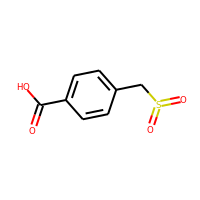
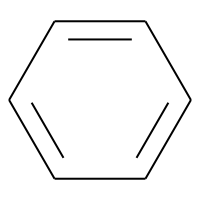
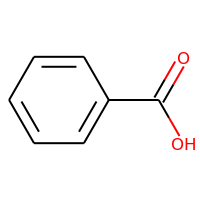
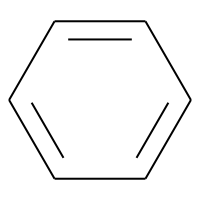
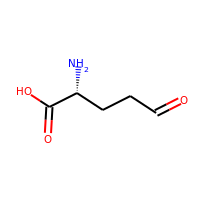
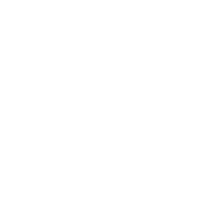
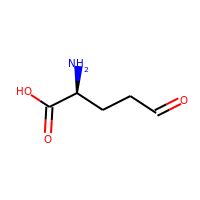
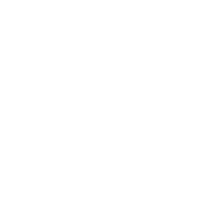
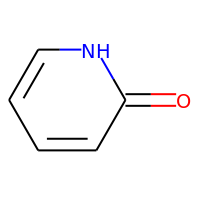
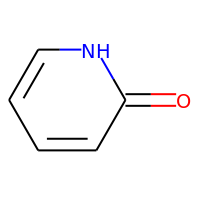
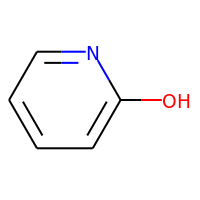
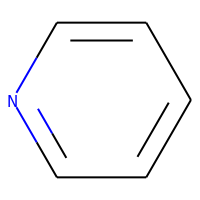
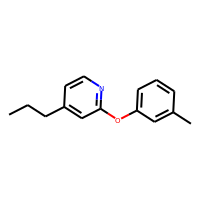
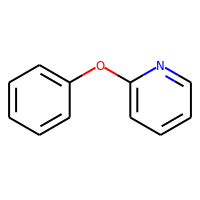
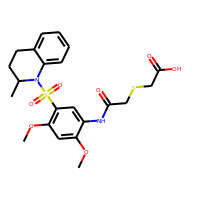
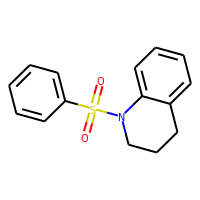
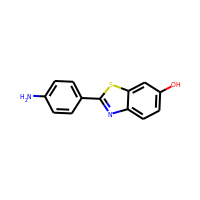
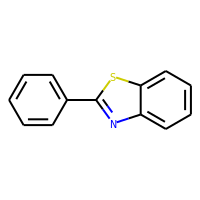
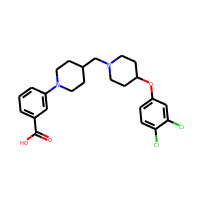
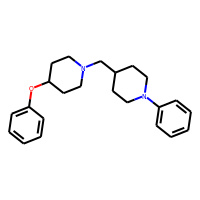
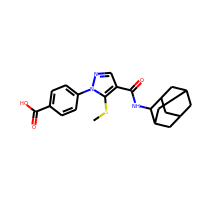
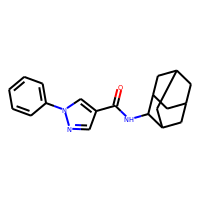

In [ ]:
data.iloc[:,2:]

## Example 2: Collecting scaffolds from a list of SMILES

In [ ]:
lipo_data = pd.read_csv('../clean_data/Lipophilicity.csv')
lipo_data.shape

(4200, 2)

In [ ]:
lipo_data.head(1)

,smiles,exp
0,Cn1c(CN2CCN(c3ccc(Cl)cc3)CC2)nc2ccccc21,3.54


In [ ]:
scaffolds = scaffold_to_smiles(lipo_data.smiles, use_indices=True)

In [ ]:
counts = 0
for i in scaffolds.keys():
    if len(scaffolds[i]) ==1:
        counts +=1
print(f'There are {counts} ({counts/len(scaffolds):.2f} of the original data) scafoolds appearing only once.')

There are 1857 (0.77 of the original data) scafoolds appearing only once.


The scaffold c1ccccc1 appears 76 times, which is the most.


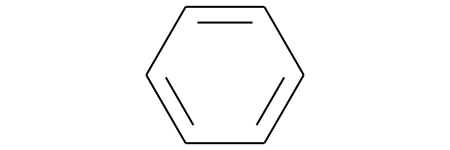

In [ ]:
max_counts = 0
for i in scaffolds.keys():
    if len(scaffolds[i]) >= max_counts:
        max_counts = len(scaffolds[i])
        scaffold_max = i
print(f'The scaffold {scaffold_max} appears {max_counts} times, which is the most.')
Chem.MolFromSmiles(scaffold_max)

## Example 3: Scaffold Split

In [ ]:
splits, splits_index = scaffold_split(lipo_data.smiles, balanced=True, seed = 0)

Total scaffolds = 2,408 | train scaffolds = 1,915 | val scaffolds = 248 | test scaffolds = 245


In [ ]:
train, val, test = splits
print(len(train), len(val), len(test))

3360 420 420


## Example 4: Random Split

In [ ]:
splits, splits_index = random_split(lipo_data.smiles, seed = 0)

In [ ]:
train, val, test = splits
print(len(train), len(val), len(test))

3360 420 420


## Example 5: Add multiple splits to a dataset.

In [ ]:
lipo_splits = generate_folds(lipo_data, 'random', num_folds=10)
lipo_splits.head(1)

,smiles,exp,random-fold-0,random-fold-1,random-fold-2,random-fold-3,random-fold-4,random-fold-5,random-fold-6,random-fold-7,random-fold-8,random-fold-9
0,Cn1c(CN2CCN(c3ccc(Cl)cc3)CC2)nc2ccccc21,3.54,0,0,0,0,0,0,2,0,0,0


We can further add `scaffold split` to the dataset.

In [ ]:
lipo_splits = generate_folds(lipo_splits, 'scaffold', num_folds=10)
lipo_splits.head(1)

Total scaffolds = 2,408 | train scaffolds = 1,951 | val scaffolds = 211 | test scaffolds = 246
Total scaffolds = 2,408 | train scaffolds = 1,947 | val scaffolds = 260 | test scaffolds = 201
Total scaffolds = 2,408 | train scaffolds = 1,887 | val scaffolds = 235 | test scaffolds = 286
Total scaffolds = 2,408 | train scaffolds = 1,984 | val scaffolds = 191 | test scaffolds = 233
Total scaffolds = 2,408 | train scaffolds = 1,906 | val scaffolds = 234 | test scaffolds = 268
Total scaffolds = 2,408 | train scaffolds = 2,041 | val scaffolds = 183 | test scaffolds = 184
Total scaffolds = 2,408 | train scaffolds = 1,894 | val scaffolds = 263 | test scaffolds = 251
Total scaffolds = 2,408 | train scaffolds = 1,907 | val scaffolds = 247 | test scaffolds = 254
Total scaffolds = 2,408 | train scaffolds = 1,917 | val scaffolds = 249 | test scaffolds = 242
Total scaffolds = 2,408 | train scaffolds = 1,905 | val scaffolds = 247 | test scaffolds = 256


,smiles,exp,random-fold-0,random-fold-1,random-fold-2,random-fold-3,random-fold-4,random-fold-5,random-fold-6,random-fold-7,...,scaffold-fold-0,scaffold-fold-1,scaffold-fold-2,scaffold-fold-3,scaffold-fold-4,scaffold-fold-5,scaffold-fold-6,scaffold-fold-7,scaffold-fold-8,scaffold-fold-9
0,Cn1c(CN2CCN(c3ccc(Cl)cc3)CC2)nc2ccccc21,3.54,0,0,0,0,0,0,2,0,...,0,0,0,0,0,0,2,0,0,0
